**Digit Generation - MNIST**

In [36]:
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Loading Dataset

In [37]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

We are interested in generating a single digit, say 9, we will extract all images containing 9 from the train dataset.

In [38]:
digit9_images = []

for i in range(len(train_images)):
  if train_labels[i] == 9:
    digit9_images.append(train_images[i])

train_images = np.array(digit9_images)
train_images.shape  

(5949, 28, 28)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


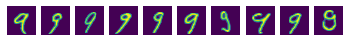

In [39]:
n = 10

f = plt.figure()

for i in range(n):
  f.add_subplot(1, n, i + 1)
  plt.subplot(1, n, i+1 ).axis("off")
  plt.imshow(train_images[i])
plt.show()

**Preparing Dataset**

In [40]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [41]:
train_images = (train_images - 127.5) / 127.5

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(32)

**Defining Generator Model**

In [43]:
gen_model = tf.keras.Sequential()
gen_model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())
gen_model.add(tf.keras.layers.Reshape((7, 7, 256)))
gen_model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())
gen_model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())
gen_model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

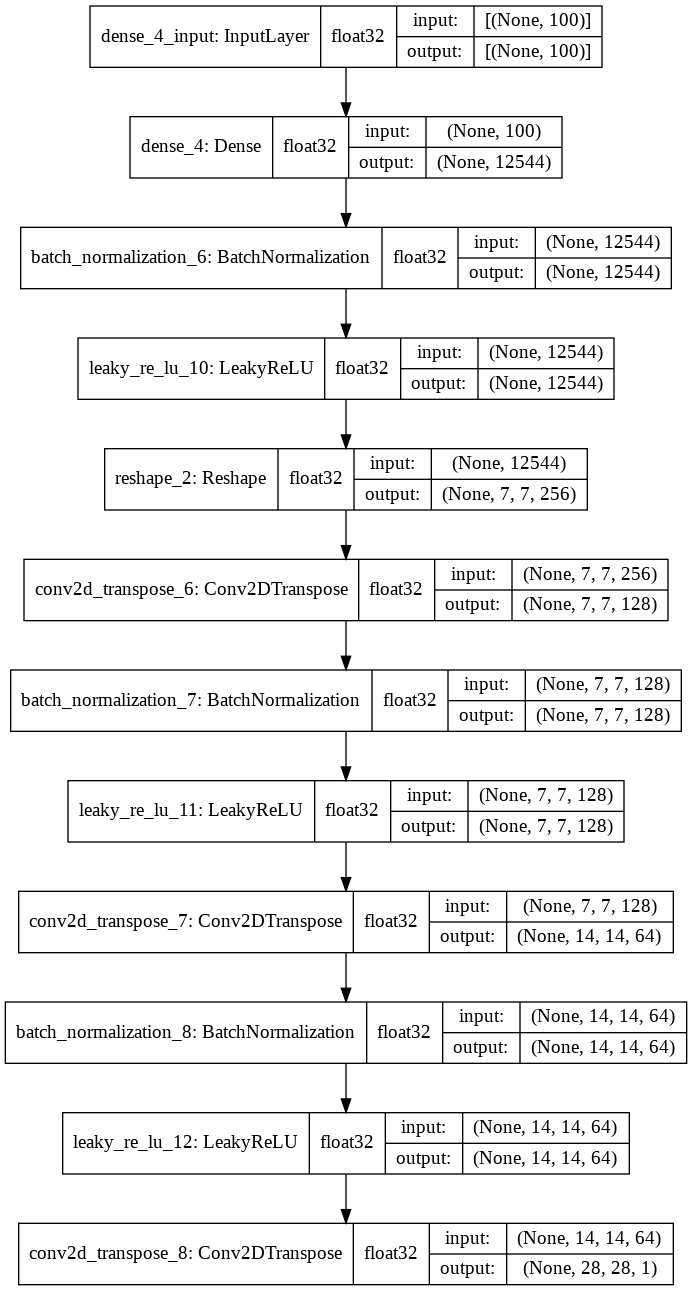

In [44]:
tf.keras.utils.plot_model(gen_model, 'generator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

In [45]:
gen_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 7, 128)        

**Testing Generator**

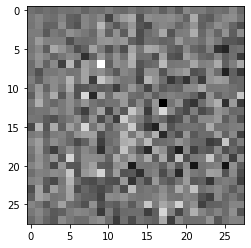

In [46]:
noise = tf.random.normal([1, 100])

#giving random input vector
generated_image = gen_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [47]:
generated_image.shape

TensorShape([1, 28, 28, 1])

**Defining Discriminator Model**

In [48]:
discri_model = tf.keras.Sequential()
discri_model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))
discri_model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))
discri_model.add(tf.keras.layers.Flatten())
discri_model.add(tf.keras.layers.Dense(1))

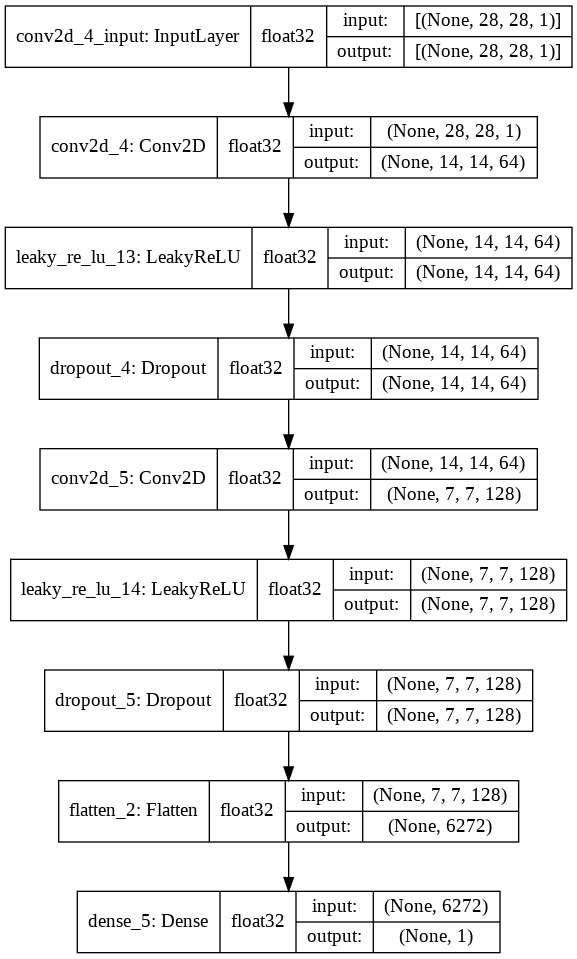

In [49]:
tf.keras.utils.plot_model(discri_model, 'discriminator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

In [50]:
discri_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

**Testing Discriminator**

In [51]:
decision = discri_model(generated_image)

In [52]:
print (decision)

tf.Tensor([[-0.00166262]], shape=(1, 1), dtype=float32)


**Defining Loss Functions**

In [53]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [54]:
def generator_loss(generated_output):
  return cross_entropy(tf.ones_like(generated_output),generated_output)

In [55]:
def discriminator_loss(real_output, generated_output):
  # compute loss considering the image is real [1,1,...,1]
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  # compute loss considering the image is fake[0,0,...,0]
  generated_loss = cross_entropy(tf.zeros_like(generated_output), generated_output)
  # compute total loss
  total_loss = real_loss + generated_loss
  return total_loss

**Optimisers**

In [56]:
gen_optimizer = tf.optimizers.Adam(1e-4)
discri_optimizer = tf.optimizers.Adam(1e-4)

**Defining Few Functions for Training**

In [58]:
epoch_number = 0
EPOCHS = 100
noise_dim = 100
seed = tf.random.normal([1, noise_dim])

**Checkpoint Setup**

In [59]:
checkpoint_dir = '/content/drive/MyDrive/Dataset/TensorFlow_GAN_CheckPoint_Output'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [60]:
checkpoint = tf.train.Checkpoint(
    generator_optimizer = gen_optimizer,
    discriminator_optimizer = discri_optimizer,
    generator = gen_model,
    discriminator = discri_model
)

**Model Training Step**

In [61]:
def gradient_tuning(images):
  # create a noise vector.
  noise = tf.random.normal([16, noise_dim])

  # Use gradient tapes for automatic
  # differentiation
  with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
    # ask genertor to generate random images
    generated_images = gen_model(noise, training=True)

    # ask discriminator to evalute the real images and generate its output
    real_output = discri_model(images, training = True)
    # ask discriminator to do the evlaution on generated(fake) images
    fake_output = discri_model(generated_images, training = True)

    # calculate generator loss on fake data
    gen_loss = generator_loss(fake_output)

    # calculate discriminator loss as defined earlier
    disc_loss = discriminator_loss(real_output, fake_output)
  
    # calculate gradients for generator
    gen_gradients = generator_tape.gradient(gen_loss, gen_model.trainable_variables)

    # calculate gradients for discriminator
    discri_gradients = discriminator_tape.gradient(disc_loss, discri_model.trainable_variables)

    # use optimizer to process and apply gradients to variables
    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    
    # same as above to discriminator
    discri_optimizer.apply_gradients(zip(discri_gradients, discri_model.trainable_variables))


In [62]:
def generate_and_save_images(model, epoch, test_input):
  global epoch_number
  epoch_number = epoch_number + 1

  # set training to false to ensure inference mode
  predictions = model(test_input, training = False)

  # display and save image
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:01d}.png'.format(epoch_number))
  plt.show()

**Model Training**

In [63]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      gradient_tuning(image_batch)

    # Produce images as we go
    generate_and_save_images(gen_model, epoch + 1, seed)

    # save checkpoint data
    checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format (epoch + 1, time.time()-start))

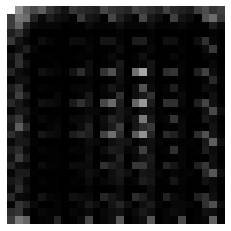

Time for epoch 1 is 82.24452877044678 sec


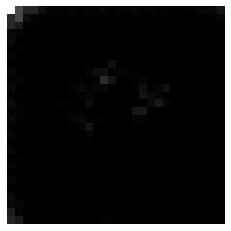

Time for epoch 2 is 76.90039992332458 sec


In [ ]:
train(train_dataset, EPOCHS)

During training and in case of disconnection, you can restore the network state from a previous known checkpoint as shown in the statement here and continue the training.

In [ ]:
#run this code only if there is a runtime disconnection
try:
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
except Exception as error:
  print("Error loading in model :{}".format(error))

train(train_dataset, EPOCHS)